# LSTM Neural Network for Stock Price Prediction

A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output. While traditional deep neural networks assume that inputs and outputs are independent of each other, the output of recurrent neural networks depend on the prior elements within the sequence.

When we observe stock price-volume data, it is also a form of sequential/time series data. It is more than likely that the stock price on a given day will be influenced by the trends/patterns seen in the price on the preceding days. One can take advantage of deep learning techniques like RNNs to learn these patterns/trends in the data and make predictions on the stock price.

LSTM (Long Short-Term Memory) is a type of RNN architecture which allows information to persist and can identify long-term dependencies. This type of network may be better suited for forecasting time series data such as stock prices as it can learn relatively long-term trends in the data and produce more accurate predictions on the future prices.

## Dataset

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

In [2]:
start_date = "2013-12-31"
end_date = "2023-12-31"


We will be using stock-price data over a duration of 10 years as markets are cyclical in nature and usually repeat their behaviour every 10 years

In [3]:
data = {}

ticker = yf.Ticker("WMT")

data['High'] = ticker.history(start = start_date, end = end_date)['High']
data['Low'] = ticker.history(start = start_date, end = end_date)['Low']
data['Close'] = ticker.history(start = start_date, end = end_date)['Close']
data['Volume'] = ticker.history(start = start_date, end = end_date)['Volume']

data = pd.DataFrame(data)

data.head()

,High,Low,Close,Volume
Date,,,,
2013-12-31 00:00:00-05:00,63.746337,63.326046,63.600853,3859100
2014-01-02 00:00:00-05:00,64.231264,63.447265,63.778648,6878000
2014-01-03 00:00:00-05:00,63.956493,63.463463,63.568539,4957400
2014-01-06 00:00:00-05:00,63.778662,62.873425,63.212887,7280200
2014-01-07 00:00:00-05:00,63.730141,62.978472,63.406841,5012300


## Technical Indicators

Technical indicators are heuristic or pattern-based signals produced by the price, volume, and/or open interest of a security. Technical indicators can be used to predict future price movements of a security and identify possible trends. These indicators can broadly be categorised into two types:

Lagging Indicators

These indicators provide delayed feedback i.e they give a signal once the price movement has already passed or is in progress. Lagging indicators can be used to confirm a price trend which has already initiated.

Leading Indicators

These indicators are used to predict the future direction of a price movement. Leading indicators are used to identify potential trends in the future and enter the market accordingly.

For the purpose of this model, a combination of both leading as well as lagging technical indicators will be fed into the network in order to follow price trends once they are in place as well as predict future trends and forecast the price accurately.

1) Relative Strength Index (RSI)

2) Williams %R (WPR)

3) Volume Weighted Average Price (VWAP)

4) Moving Average Convergence-Divergence (MACD)

In [4]:
import pandas_ta as ta

In [5]:
data['RSI'] = ta.rsi(data.Close, length = 14)
data['WPR'] = ta.willr(data.High, data.Low, data.Close, length = 14)
data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)
data['MACD'] = ta.ema(data.Close, length = 12) - ta.ema(data.Close, length = 26)

/var/folders/xm/_6m30k1j1kbgb2ps1nz6t4d00000gn/T/ipykernel_85010/2209731584.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)


Creating buy/sell trading signals using the indicator data to feed into the network for predicting the future stock price movement:

In [6]:
rsi_signal = []
for rsi in data['RSI']:
  if rsi > 70:
    rsi_signal.append(-1)
  elif rsi < 30:
    rsi_signal.append(1)
  else:
    rsi_signal.append(0)

data['RSI_signal'] = rsi_signal

wpr_signal = []
for wpr in data['WPR']:
  if wpr > -20:
    wpr_signal.append(-1)
  elif wpr < -80:
    wpr_signal.append(1)
  else:
    wpr_signal.append(0)

data['WPR_signal'] = wpr_signal

## Target Variable

For the purpose of this model, we will be predicting the next day stock price on the basis of data fed in from the previous 14 days. The target variable will be defined as the "Close" stock price for the next day.

In [7]:
data['TargetNextClose'] = data['Close'].shift(-1)
data.dropna(inplace = True)
data.reset_index(inplace = True)

data.head()

,Date,High,Low,Close,Volume,RSI,WPR,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,2014-02-06 00:00:00-05:00,59.171664,58.597811,58.856449,7353100,23.115414,-87.911787,58.875308,-1.566625,1,1,59.608105
1,2014-02-07 00:00:00-05:00,59.648519,58.597798,59.608105,7287600,35.181908,-64.077874,59.284807,-1.472982,0,0,59.616196
2,2014-02-10 00:00:00-05:00,59.616196,58.969597,59.616196,6204100,35.299618,-60.892198,59.400663,-1.382184,0,0,60.456768
3,2014-02-11 00:00:00-05:00,60.497177,59.543447,60.456768,6511200,46.225456,-19.169226,60.165797,-1.228240,0,-1,60.586098
4,2014-02-12 00:00:00-05:00,60.763913,59.987998,60.586098,5339800,47.689140,-14.057009,60.446003,-1.083315,0,-1,60.909386


In [8]:
data_set = data.iloc[:, 1:12]

pd.set_option('display.max_columns', None)

data_set.head()

,High,Low,Close,Volume,RSI,WPR,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,59.171664,58.597811,58.856449,7353100,23.115414,-87.911787,58.875308,-1.566625,1,1,59.608105
1,59.648519,58.597798,59.608105,7287600,35.181908,-64.077874,59.284807,-1.472982,0,0,59.616196
2,59.616196,58.969597,59.616196,6204100,35.299618,-60.892198,59.400663,-1.382184,0,0,60.456768
3,60.497177,59.543447,60.456768,6511200,46.225456,-19.169226,60.165797,-1.228240,0,-1,60.586098
4,60.763913,59.987998,60.586098,5339800,47.689140,-14.057009,60.446003,-1.083315,0,-1,60.909386


## Feature Scaling

Since the model will be using a variety of data having different magnitude and scale, all the input variables will be normalised into a range of 0 to 1. This will assist the deep learning model during training as the gradient descent step will be faster. It will also help ensure that the training process does not fail due to problems such as exploding gradient.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_feature_train = MinMaxScaler(feature_range = (0, 1))
scaler_feature_test = MinMaxScaler(feature_range = (0, 1))
scaler_target_train = MinMaxScaler(feature_range = (0, 1))
scaler_target_test = MinMaxScaler(feature_range = (0, 1))

feature_set = data_set.drop(['TargetNextClose'], axis = 1)

target_set = np.array(data_set['TargetNextClose']).reshape(-1, 1)

In [10]:
splitlimit = int(len(feature_set) * 0.8)

feature_set_train, feature_set_test = feature_set[:splitlimit], feature_set[splitlimit:]
feature_set_train_scaled = scaler_feature_train.fit_transform(feature_set_train)
feature_set_test_scaled = scaler_feature_test.fit_transform(feature_set_test)

target_set_train, target_set_test = target_set[:splitlimit], target_set[splitlimit:]
target_set_train_scaled = scaler_target_train.fit_transform(target_set_train)
target_set_test_scaled = scaler_target_test.fit_transform(target_set_test)

## Constructing the dataset



Input data to the network will be a series of dataframes having the feature data over a lookback period of 14 days. The lookback window will roll over the entire data time period and will be used to predict the Close price of the next day.

In [11]:
X_train = []

backcandles = 14
features = 10

for i in range(features):
    X_train.append([])

    for j in range(backcandles, feature_set_train_scaled.shape[0]):
        X_train[i].append(feature_set_train_scaled[j-backcandles: j, i])

X_train = np.moveaxis(X_train, [0], [2])

X_test = []

for i in range(features):
    X_test.append([])

    for j in range(backcandles, feature_set_test_scaled.shape[0]):
        X_test[i].append(feature_set_test_scaled[j-backcandles: j, i])

X_test = np.moveaxis(X_test, [0], [2])

X_train, X_test = np.array(X_train), np.array(X_test)
Yi, Yj = np.array(target_set_train_scaled[backcandles:]), np.array(target_set_test_scaled[backcandles:]),
Y_train, Y_test = np.reshape(Yi, (len(Yi), 1)), np.reshape(Yj, (len(Yj), 1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1978, 14, 10)
(485, 14, 10)
(1978, 1)
(485, 1)


## Building and training the LSTM neural network

In [12]:
# Define your model
import tensorflow as tf
from tensorflow import keras

# Define your model
lstm_input = keras.layers.Input(shape=(backcandles, features), name='lstm_input')
lstm1 = keras.layers.LSTM(100, return_sequences=True, name='firstLSTM_layer')(lstm_input)
lstm2 = keras.layers.LSTM(75, name='secondLSTM_layer')(lstm1)
dense = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(lstm2)
dropout = keras.layers.Dropout(0.2)(dense)
out = keras.layers.Dense(1, name='output')(dropout)

model = keras.models.Model(inputs=lstm_input, outputs=out)

# Compile the model with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=adam, loss='mse', metrics=['mae'])

# Train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(x=X_train, y=Y_train, batch_size=15, epochs=100, shuffle=True, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, mae = model.evaluate(x=X_test, y=Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")





Epoch 1/100
132/132 [==============================] - 3s 9ms/step - loss: 0.0568 - mae: 0.0651 - val_loss: 0.0367 - val_mae: 0.0659
Epoch 2/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0242 - mae: 0.0414 - val_loss: 0.0210 - val_mae: 0.0552
Epoch 3/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0153 - mae: 0.0427 - val_loss: 0.0147 - val_mae: 0.0532
Epoch 4/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0099 - mae: 0.0378 - val_loss: 0.0118 - val_mae: 0.0544
Epoch 5/100
132/132 [==============================] - 1s 8ms/step - loss: 0.0074 - mae: 0.0364 - val_loss: 0.0093 - val_mae: 0.0508
Epoch 6/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0060 - mae: 0.0366 - val_loss: 0.0090 - val_mae: 0.0573
Epoch 7/100
132/132 [==============================] - 1s 8ms/step - loss: 0.0050 - mae: 0.0362 - val_loss: 0.0076 - val_mae: 0.0507
Epoch 8/100
132/132 [==============================] - 1s 9ms/step - 

132/132 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0439
Epoch 63/100
132/132 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0275 - val_loss: 0.0045 - val_mae: 0.0448
Epoch 64/100
132/132 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0451
Epoch 65/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0046 - val_mae: 0.0459
Epoch 66/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0045 - val_mae: 0.0453
Epoch 67/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0042 - val_mae: 0.0438
Epoch 68/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.0044 - val_mae: 0.0448
Epoch 69/100
132/132 [==============================] - 1s 8ms/step - loss:

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 14, 10)]          0         
                                                                 
 firstLSTM_layer (LSTM)      (None, 14, 100)           44400     
                                                                 
 secondLSTM_layer (LSTM)     (None, 75)                52800     
                                                                 
 dense (Dense)               (None, 64)                4864      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 102129 (398.94 KB)
Trainable params: 102129 (39

## Test Data Predictions

In [14]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 0s 3ms/step


## Predicted price vs Actual price

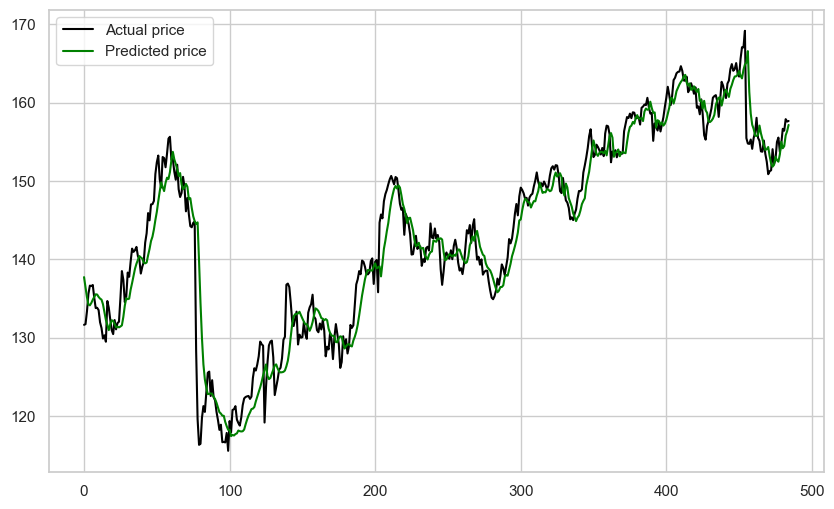

In [15]:
import matplotlib.pyplot as plt

# Inverse transform the scaled predictions to the original scale
Y_test_prices = scaler_target_test.inverse_transform(Y_test)
Y_pred_prices = scaler_target_test.inverse_transform(Y_pred)

# Plot the actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(Y_test_prices, color='black', label='Actual price')
plt.plot(Y_pred_prices, color='green', label='Predicted price')
plt.legend()
plt.show()

## Evaluation Metrics

Following evaluation metrics are used to analyse the performance of the model:

1) Correlation
2) Cointegration test
3) Root mean square error (RMSE)

## Root Mean Square Error (RMSE)

## 1) Correlation

In [16]:
predicted_values = Y_pred.ravel()
actual_values = Y_test.ravel()
correlation = np.corrcoef(actual_values, predicted_values)[0, 1]
print("Correlation between actual and predicted values:", correlation)

Correlation between actual and predicted values: 0.9640677749415191


## 2) Cointegration Test

In [ ]:
import numpy as np
import statsmodels.tsa.stattools as ts

# Performing the cointegration test
coint_result = ts.coint(Y_test_prices[0], Y_pred_prices[0], trend='c') 

# Specifying the trend parameter as 'c' (constant) or 'ct' (constant and trend)
p_val = coint_result[1]

print("P-Value for the cointegration test:")
print(np.round(p_val, 1000))


The cointegration test results in a P-value which is practically 0 as "float division by zero" is coming. This indicates that the time series of the predicted prices and the actual prices are highly cointegration i.e they show a strong positive correlation over their duration

## 3) Root Mean Square Error (RMSE)¶

In [18]:
rmse = np.round(np.sqrt(np.mean(((Y_test_prices[0] - Y_pred_prices[0])/Y_test_prices[0])**2)), 3)
print("Root Mean Square Error (RMSE) =", np.round(rmse*100, 3), "%")

Root Mean Square Error (RMSE) = 4.6 %
